# Benchmark `oxidized_thainlp.segment`

Benchmarks Rust `oxidized_thainlp.segment` (unsafe) against Python `newmm.segment` (unsafe) using the same dictionary.

https://github.com/PyThaiNLP/oxidized-thainlp/

In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset
from tqdm.auto import tqdm


def time_func(func, arg):
    start_time = time.time()
    func(arg)
    return time.time() - start_time

## Load Test data

In [2]:
datasets = load_dataset('wisesight_sentiment')
datasets

Reusing dataset wisesight_sentiment (/Users/test/.cache/huggingface/datasets/wisesight_sentiment/wisesight_sentiment/1.0.0/fc2b1bdfe79571b2e281e4afdb5aac069cf9270bf0f85694239be672a4191969)


DatasetDict({
    train: Dataset({
        features: ['category', 'texts'],
        num_rows: 21628
    })
    validation: Dataset({
        features: ['category', 'texts'],
        num_rows: 2404
    })
    test: Dataset({
        features: ['category', 'texts'],
        num_rows: 2671
    })
})

In [3]:
txt = datasets['train']['texts'][0]
txt

'ไปจองมาแล้วนาจา Mitsubishi Attrage ได้หลังสงกรานต์เลย รอขับอยู่นาจา กระทัดรัด เหมาะกับสาวๆขับรถคนเดียวแบบเรา ราคาสบายกระเป๋า ประหยัดน้ำมัน วิ่งไกลแค่ไหนหายห่วงค่ะ'

## Load Custom Dictionary

Both `oxidized_newmm()` and `py_newmm()` will use the same word list (`words_th.txt`)

In [4]:
DICT_FILE = "../rust_modules/words_th.txt"

In [5]:
from oxidized_thainlp import load_dict
from oxidized_thainlp import segment as oxidized_segment

load_dict(DICT_FILE, "test_dict")  # create "test_dict" dictionary

def oxidized_newmm(txt, safe=False, parallel=False):
    return oxidized_segment(txt, dict_name="test_dict", safe=safe, parallel=parallel)

oxidized_newmm(txt)[:10]

Successful: dictionary name test_dict from file ../rust_modules/words_th.txt has been successfully loaded


['ไป', 'จอง', 'มา', 'แล้', 'วนา', 'จา', ' ', 'Mitsubishi', ' ', 'Attrage']

In [6]:
from pythainlp.tokenize.newmm import segment as py_segment
from pythainlp.util import dict_trie

trie = dict_trie(dict_source=DICT_FILE)

def py_newmm(txt, safe_mode=False):
    return py_segment(txt, safe_mode=safe_mode, custom_dict=trie)

py_newmm(txt)[:10]

['ไป', 'จอง', 'มา', 'แล้', 'วนา', 'จา', ' ', 'Mitsubishi', ' ', 'Attrage']

## One Example

In [7]:
txt = datasets['train']['texts'][0]
txt

'ไปจองมาแล้วนาจา Mitsubishi Attrage ได้หลังสงกรานต์เลย รอขับอยู่นาจา กระทัดรัด เหมาะกับสาวๆขับรถคนเดียวแบบเรา ราคาสบายกระเป๋า ประหยัดน้ำมัน วิ่งไกลแค่ไหนหายห่วงค่ะ'

### Average Run Time for One Example

In [8]:
%timeit py_newmm(txt)

301 µs ± 5.35 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [9]:
%timeit oxidized_newmm(txt)

167 µs ± 849 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [10]:
%timeit oxidized_newmm(txt, parallel=True)

250 µs ± 15.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [11]:
%timeit py_newmm(txt, safe_mode=True)

307 µs ± 3.61 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [12]:
%timeit oxidized_newmm(txt, safe=True)

172 µs ± 2.05 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## All Examples in `wisesight_sentiment`

### Check If Results Match for All Examples

In [13]:
corrects = [oxidized_newmm(txt) == py_newmm(txt) for txt in datasets['train']['texts']]
np.mean(corrects), len(corrects)

(0.9999075272794525, 21628)

### Average Run Time Across All Examples

In [14]:
py_newmms = [time_func(py_newmm, txt) for txt in datasets['train']['texts']]
oxidized_newmms = [time_func(oxidized_newmm, txt) for txt in datasets['train']['texts']]

# oxidized newmm is nearly 2 times faster on average.
np.mean(py_newmms), np.mean(oxidized_newmms), np.mean(py_newmms) / np.mean(oxidized_newmms)

(0.00019656274683355998, 0.00010971316837969033, 1.7916057820270452)

(array([1.517e+04, 3.306e+03, 1.203e+03, 8.310e+02, 3.820e+02, 2.200e+02,
        1.410e+02, 9.200e+01, 5.700e+01, 5.200e+01, 3.900e+01, 2.300e+01,
        2.800e+01, 1.700e+01, 6.000e+00, 9.000e+00, 8.000e+00, 8.000e+00,
        9.000e+00, 8.000e+00, 5.000e+00, 4.000e+00, 3.000e+00, 3.000e+00,
        0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00]),
 array([4.76837158e-06, 9.86099243e-05, 1.92451477e-04, 2.86293030e-04,
        3.80134583e-04, 4.73976135e-04, 5.67817688e-04, 6.61659241e-04,
        7.55500793e-04, 8.49342346e-04, 9.43183899e-04, 1.03702545e-03,
        1.13086700e-03, 1.22470856e-03, 1.31855011e-03, 1.41239166e-03,
        1.50623322e-03, 1.60007477e-03, 1.69391632e-03, 1.78775787e-03,
        1.88159943e-03, 1.97544098e-03, 2.06928253e-03, 2.16312408e-03,
        2.25696564e-03, 2.35080719e-03, 2.44464874e-03, 2.53849030e-03,
        2.63233185e-03, 2.72617340e-03, 2.82001495e-03]),
 <BarContainer object of 30 artists>)

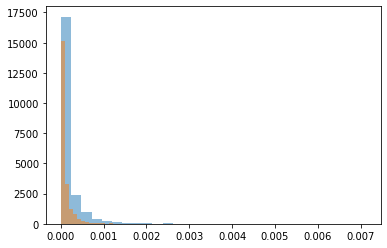

In [15]:
# look at distribution; oxidized newmm also consistently performs better
plt.hist(py_newmms, bins=30, alpha=0.5)
plt.hist(oxidized_newmms, bins=30, alpha=0.5)

## Run Time as Sequence Length Grows

In [16]:
txt = datasets['train']['texts'][1]
txt2 = ''.join(oxidized_newmm(txt)[:10])
txt2, len(oxidized_newmm(txt2))

('เปิดศักราชใหม่! นายกฯ แถลงข่าวก่อนการแข่งขัน', 10)

In [17]:
py_newmms = [time_func(py_newmm, txt2*i) for i in tqdm([10**j for j in range(5)])]
oxidized_newmms = [time_func(oxidized_newmm, txt2*i) for i in tqdm([10**j for j in range(5)])]

Performance starts really deviate when sequence length > 10^3 tokens and above.

python newmm is dashed line.

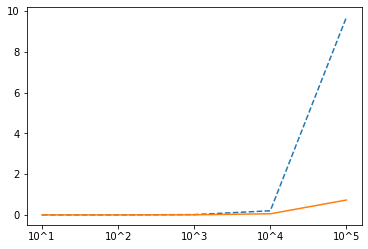

In [18]:
positions = [i for i in range(5)]
labels = [f'10^{i+1}' for i in range(5)]
plt.xticks(positions, labels)
plt.plot(py_newmms, linestyle='dashed')
plt.plot(oxidized_newmms)

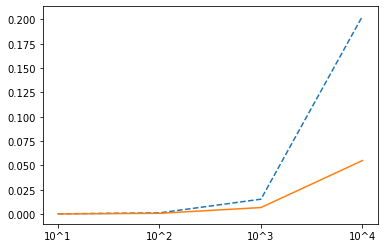

In [19]:
# zooming in on inflexion point
positions = [i for i in range(4)]
labels = [f'10^{i+1}' for i in range(4)]
plt.xticks(positions, labels)
plt.plot(py_newmms[:-1], linestyle='dashed')
plt.plot(oxidized_newmms[:-1])